In [229]:
using QuantumOptics
using PyPlot
using LaTeXStrings
using Random
using DelimitedFiles
using NPZ, Printf
using LinearAlgebra
using DifferentialEquations
using SpecialFunctions
using SparseArrays
using StatsBase
using Optim

In [230]:
function mb(op,bases,idx)

    numHilberts = size(bases,1)

    if idx==1
        mbop = op
    else
        mbop = identityoperator(bases[1])
    end

    for i=2:numHilberts

        if i==idx
            mbop = tensor(mbop,op)
        else
            mbop = tensor(mbop,identityoperator(bases[i]))
        end

    end

    return mbop
end

mb (generic function with 1 method)

In [340]:
seed = Int(round(mod(time()*300,1000)))
W = RealWienerProcess(0.,0.)

fockmax = 15
Nspin = 10
fb = FockBasis(fockmax)
sb = SpinBasis(Nspin//2)
bases = [sb, fb]
a = mb(destroy(fb), bases, 2)
Sx = mb(sigmax(sb), bases, 1)
Sy = mb(sigmay(sb), bases, 1)
Sz = mb(sigmaz(sb), bases, 1)

κ = 0.001
Δc = 10.0
ωz = 1.0
λc = 1/2*sqrt((Δc^2+κ^2)/Δc * ωz) 
λ = 1.5*λc
free_energy(α) = Δc*(α[1]^2) - Nspin*sqrt((ωz^2)/4 + (α[1]^2)*(4*λ^2)/Nspin)
result = optimize(free_energy, ones(1), BFGS())
αinit = Optim.minimizer(result)[1]
φinit = atan(ωz/2, 2*λ*αinit/sqrt(Nspin))

dt=0.00001
timesteps = 100000
tspan = dt*collect(1:timesteps)

C = 2*sqrt(κ)*a
H0 = Δc*dagger(a)*a + ωz*Sz + 2*λ*(dagger(a) + a)*Sx/sqrt(Nspin)

ψ0 = tensor(spindown(sb), coherentstate(fb,αinit))# + coherentstate(b,-0.7))
ψ0 = exp(im*φinit/2*Sy)*ψ0
ψ0 = normalize!(ψ0);
@assert abs(expect(mb(projector(basisstate(fb, 11)), bases, 2), ψ0)) < 0.01

In [341]:
θ = 0.5π
Hs = 1.0im*C*exp(-1.0im*θ)
Y = C*exp(-1.0im*θ) + dagger(C)*exp(1.0im*θ)
CdagC = -0.5im*dagger(C)*C
H_nl(ψ) = expect(Y, normalize(ψ))*Hs + CdagC

fdet_homodyne(t, ψ) = H0 + H_nl(ψ)
fst_homodyne(t, ψ) = [Hs]

tout, psi_t = stochastic.schroedinger_dynamic(tspan, ψ0, fdet_homodyne, fst_homodyne; dt=dt, normalize_state=true, noise=W, seed=seed);

In [342]:
function window(signal::Vector{Float64}, time::Vector{Float64}, dt::Float64)::Vector{Float64}
    Ntime = length(time)
    Ttotal = time[Ntime] - time[1]
    Nfilt = Int64(ceil(Ttotal/dt))
    filtered = zeros(Nfilt)
    time_indx = 1
    for i=1:Nfilt
        window_size = 0
        while time_indx <= Ntime && time[time_indx] < dt*(i+1)
            # print(time_indx, " ", Ntime,"\n")
            window_size += 1
            # print(length(filtered), " ", Nfilt, "\n")
            filtered[i] += signal[time_indx]
            time_indx += 1
        end
        filtered[i] /= window_size
    end
    return filtered
end

function filter(signal::Vector{Float64}, time_scale::Float64, dt::Float64)::Vector{Float64}
    N = length(signal)
    filtered = zeros(N)
    for i=2:N
        filtered[i] = filtered[i-1]*exp(-dt/time_scale) + signal[i]*(dt/time_scale)
        # filtered[i] = filtered[i-1]*0.9 + 0.2*homodyne_[i]
    end
    return filtered 
end

function two_point_correlator(signal::Vector{Float64}, time::Vector{Float64}, dt::Float64, time_steps::Int;prefilter::Union{Nothing, Float64}=nothing, delay_start::Union{Nothing, Integer}=nothing)::Vector{Float64}
    if delay_start != nothing
        signal = signal[delay_start:length(signal)]
        time = time[delay_start:length(time)]
    end
    signal = window(signal, time, dt)
    N = length(signal)
    if prefilter != nothing
        signal = filter(signal, prefilter, dt)
        N = N-1
    end
    rslt = zeros(time_steps)
    avg = sum(signal[1:N])/N
    for i = 1:time_steps
        rslt[i] = sum(signal[1:N-i] .* signal[i+1:N])/(N-i) - (avg)^2
    end
    return rslt
end

two_point_correlator (generic function with 1 method)

In [343]:
dW = W.u[2:timesteps+1]-W.u[1:timesteps]
Jhom = real(expect(a+dagger(a), psi_t)) + dW;

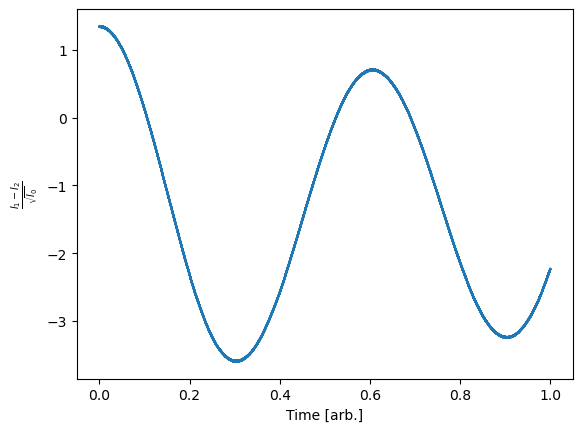

In [344]:
plot(tout, Jhom)
xlabel("Time [arb.]")
ylabel(L"$\frac{I_1-I_2}{\sqrt{I_0}}$")
PyPlot.display_figs()

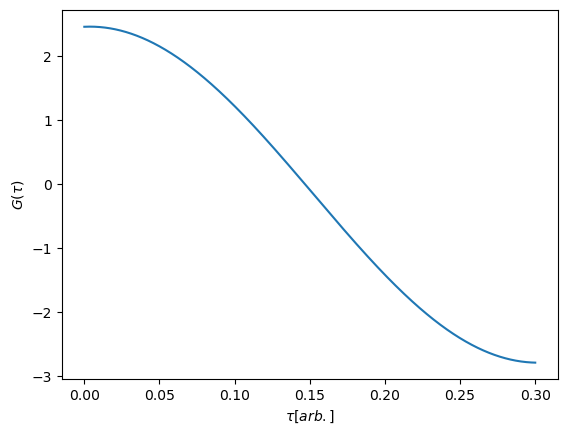

In [345]:
plot(dt*collect(1:30000), two_point_correlator(Jhom, tout, dt, 30000))
xlabel(L"\tau [arb.]")
ylabel(L"$G(\tau)$")
PyPlot.display_figs()

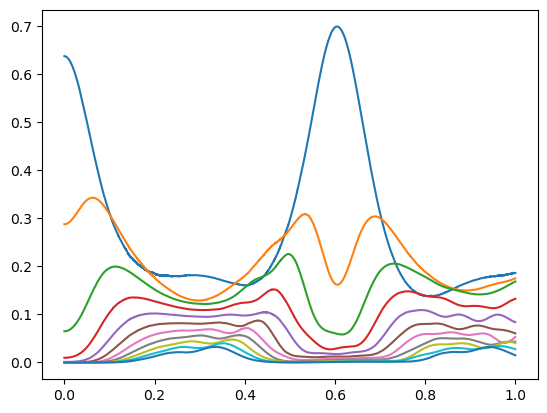

In [346]:
plot(tout, real(expect(mb(projector(basisstate(fb, 1)), bases, 2), psi_t)))
plot(tout, real(expect(mb(projector(basisstate(fb, 2)), bases, 2), psi_t)))
plot(tout, real(expect(mb(projector(basisstate(fb, 3)), bases, 2), psi_t)))
plot(tout, real(expect(mb(projector(basisstate(fb, 4)), bases, 2), psi_t)))
plot(tout, real(expect(mb(projector(basisstate(fb, 5)), bases, 2), psi_t)))
plot(tout, real(expect(mb(projector(basisstate(fb, 6)), bases, 2), psi_t)))
plot(tout, real(expect(mb(projector(basisstate(fb, 7)), bases, 2), psi_t)))
plot(tout, real(expect(mb(projector(basisstate(fb, 8)), bases, 2), psi_t)))
plot(tout, real(expect(mb(projector(basisstate(fb, 9)), bases, 2), psi_t)))
plot(tout, real(expect(mb(projector(basisstate(fb, 10)), bases, 2), psi_t)))
plot(tout, real(expect(mb(projector(basisstate(fb, 11)), bases, 2), psi_t)))
PyPlot.display_figs()

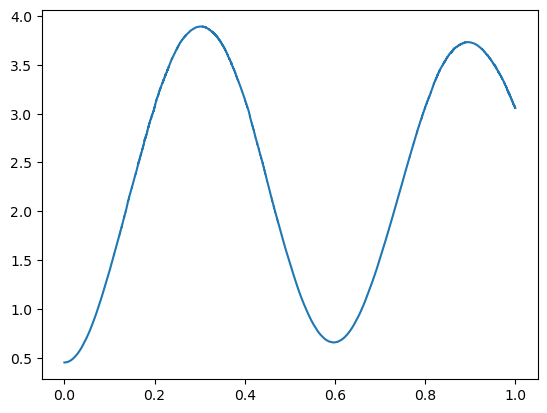

In [347]:
plot(tout, expect(dagger(a)*a, psi_t))
PyPlot.display_figs()

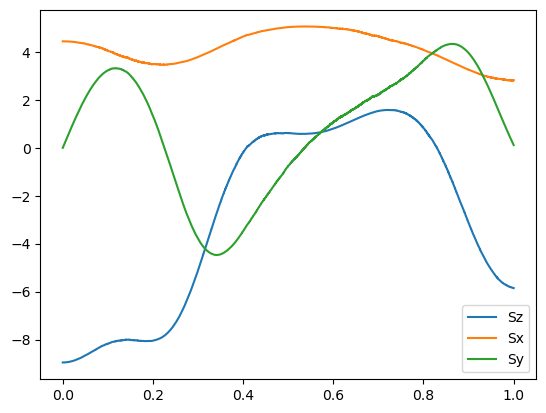

In [348]:
plot(tout, expect(Sz, psi_t))
plot(tout, expect(Sx, psi_t))
plot(tout, expect(Sy, psi_t))
PyPlot.legend(["Sz", "Sx", "Sy"])
PyPlot.display_figs()